In [1]:
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image, plotting
from nilearn.masking import intersect_masks

from survey_medley_code.config_loader import load_config
from survey_medley_code.within_subject_modeling.io_utils import (
    get_subids_bids_dir,
)
from survey_medley_code.within_subject_modeling.timeseries_utils import (
    get_files,
)

In [2]:
cfg = load_config()
subids = get_subids_bids_dir(cfg)

In [3]:
# First, a simple exclusion based on whether or not subjects have data

subs_lacking_data = []

for subid in subids:
    try:
        files = get_files(cfg, subid)
    except Exception:
        subs_lacking_data.append(subid)
        continue

In [4]:
subs_lacking_data_df = pd.DataFrame({'subid': subs_lacking_data})
subs_lacking_data_df['secondary_missing_data_test'] = 1


In [5]:
exclusion_path = cfg.bids_dir / 'suggested_exclusions.csv'
exclusions = pd.read_csv(exclusion_path)

# Patrick doesn't want us to use "missing_more_than_half_the_tasks"
exclusions = exclusions.drop(columns=['missing_more_than_half_the_tasks'])
# omit rows without any 1s
exclusions = exclusions[exclusions.iloc[:, 1:].sum(axis=1) > 0]

In [6]:
survey_exclusions = exclusions.copy()
survey_exclusions = survey_exclusions[
    survey_exclusions['Unnamed: 0'].str.contains('surveyMedley', na=False)
]
survey_exclusions.rename(columns={'Unnamed: 0': 'subid'}, inplace=True)
survey_exclusions.loc[:, 'subid'] = survey_exclusions['subid'].str.replace(
    '_surveyMedley', '', regex=False
)


In [7]:
merged_exclusions = pd.merge(
    subs_lacking_data_df,
    survey_exclusions,
    on='subid',  # or 'subid' if that's the column name
    how='outer',  # keeps all rows from both DataFrames
)
merged_exclusions = merged_exclusions.fillna(0)

### Notes about oddities in following figure
The `secondary_missing_data_test` column assess whether that subject has fmriprep data and behavioral data, yet sometimes a subject is flagged by this measure, but wasn't flagged in Jaime's `missing_beh_data`.  Here is why (for the impacted subjects)

* **s599**: Flagged by the secondary measure, but not Jaime's measure because the fmriprep directory does not exist (so we don't have BOLD data to use)
* **s646**:  Not flagged by the secondary measure, but the behavioral data must have been found after Jaime assessed the data.  Therefore, Jaime's measure should be ignored here

We should ignore the `missing_beh_data` column, but use the more accurate `secondary_missing_data_test` column instead.

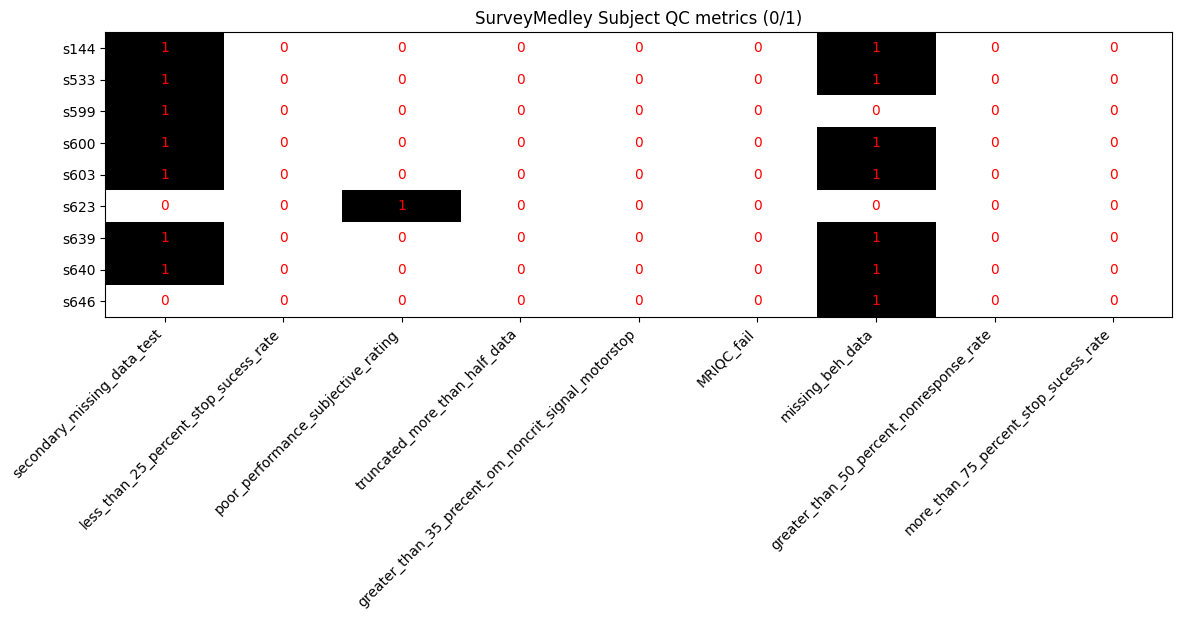

In [8]:
# Suppose survey_rows is your filtered DataFrame
# Drop the 'Unnamed: 0' column for plotting
data = merged_exclusions.drop(columns=['subid']).values
subjects = merged_exclusions['subid'].values
columns = merged_exclusions.drop(columns=['subid']).columns

fig, ax = plt.subplots(
    figsize=(12, len(subjects) * 0.7)
)  # height scales with # of subjects
im = ax.imshow(data, cmap='Greys', aspect='auto')  # Greys: 0=white, 1=black

# Set ticks
ax.set_yticks(np.arange(len(subjects)))
ax.set_yticklabels(subjects)
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=45, ha='right')

# Optionally, add values on the cells
for i in range(len(subjects)):
    for j in range(len(columns)):
        ax.text(j, i, str(int(data[i, j])), ha='center', va='center', color='red')

ax.set_title('SurveyMedley Subject QC metrics (0/1)')
plt.tight_layout()
plt.show()

In [9]:
# Check how many of these subjects were run
outdir = Path(
    '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results'
)

for subj in merged_exclusions['subid']:
    subj_no_s = str.replace(subj, 's', '')
    subdir_path = outdir / subj_no_s
    if subdir_path.exists() and subdir_path.is_dir():
        print(f'Found: {subdir_path}')


In [10]:
def dice(mask1, mask2):
    m1 = image.get_data(mask1).astype(bool)
    m2 = image.get_data(mask2).astype(bool)

    intersection = np.logical_and(m1, m2).sum()
    size1 = m1.sum()
    size2 = m2.sum()

    if size1 + size2 == 0:
        return np.nan
    return 2 * intersection / (size1 + size2)

In [11]:
mask_output_dir = Path(
    '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks'
)

mask_list = list(mask_output_dir.glob('*.nii.gz'))
print(f'Found {len(mask_list)} BOLD files.')


Found 104 BOLD files.


In [12]:
aggregate_mask = intersect_masks(mask_list, threshold=0.3)

In [25]:
# save the mask to use with Randomise
aggregate_mask.to_filename(
    cfg.output_root / 'assess_subject_bold_dropout/group_mask_intersection_30pct.nii.gz'
)

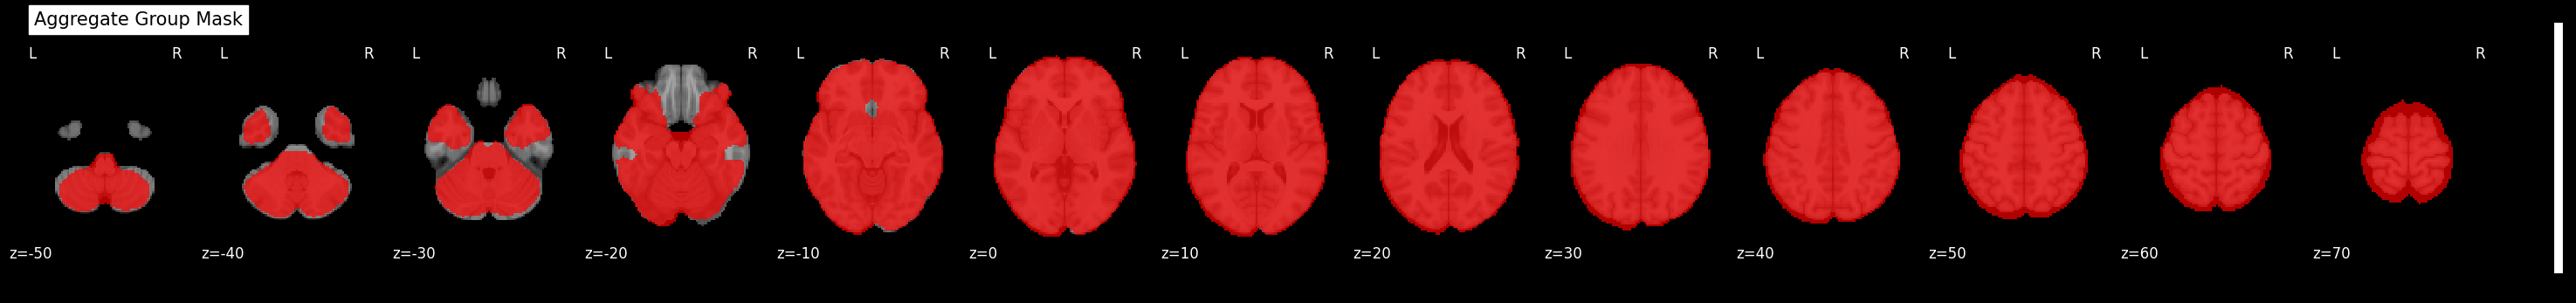

In [13]:
z_slices = np.arange(-50, 71, 10)

plotting.plot_roi(
    aggregate_mask,
    display_mode='z',
    cut_coords=z_slices,
    cmap='autumn',
    black_bg=True,
    title='Aggregate Group Mask',
)
plt.show()

In [14]:
dice_scores = []
for mask_path in mask_list:
    m = image.load_img(mask_path)
    d = dice(m, aggregate_mask)
    dice_scores.append(d)

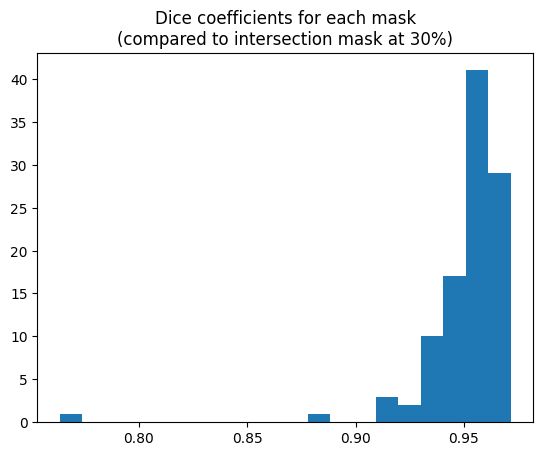

In [15]:
plt.hist(dice_scores, 20)
plt.title('Dice coefficients for each mask\n(compared to intersection mask at 30%)')
plt.show()

### How I'm assessing the masks
A threshold of 0.9 looks like it will exclude the outliers, based on the histogram.  To be thorough, I'm setting it to 0.93 in the following loop and then I'm visually inpecting the mean image in the `mask_and_mean_QA.pdf` to see whether mask oddities are due to real structure getting picked up (mask too big), typical dropout (mask too small in areas) or data that appear to be corrupted in some way.

Plotting /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks/sub-s640.nii.gz (Dice=0.924)


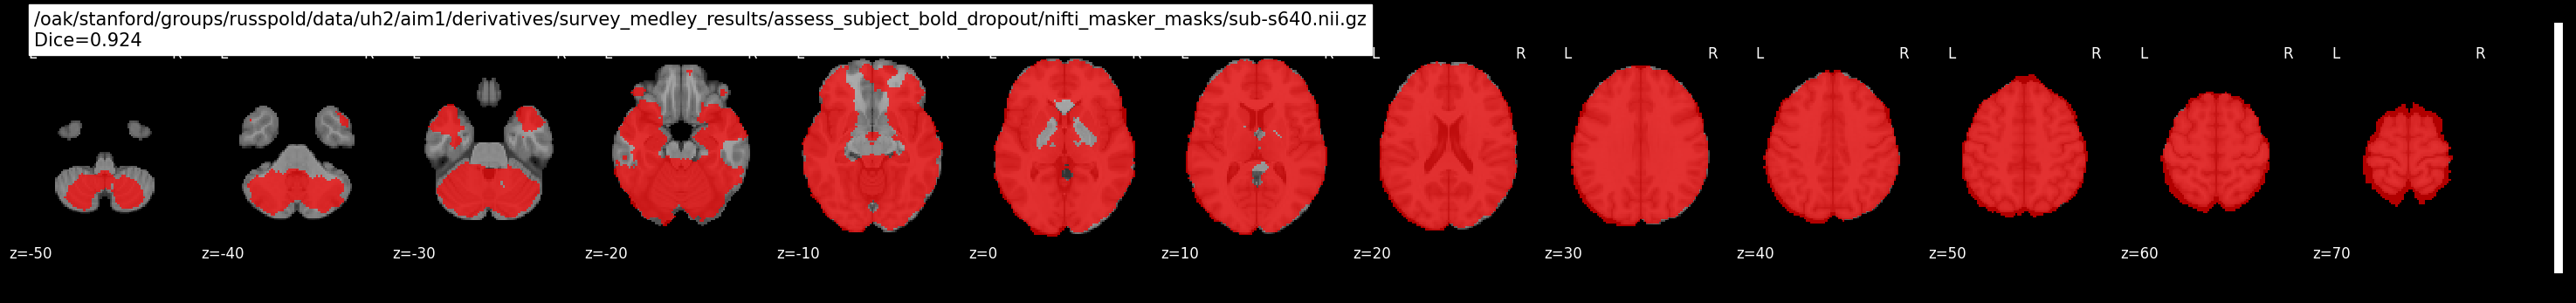

Plotting /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks/sub-s584.nii.gz (Dice=0.924)


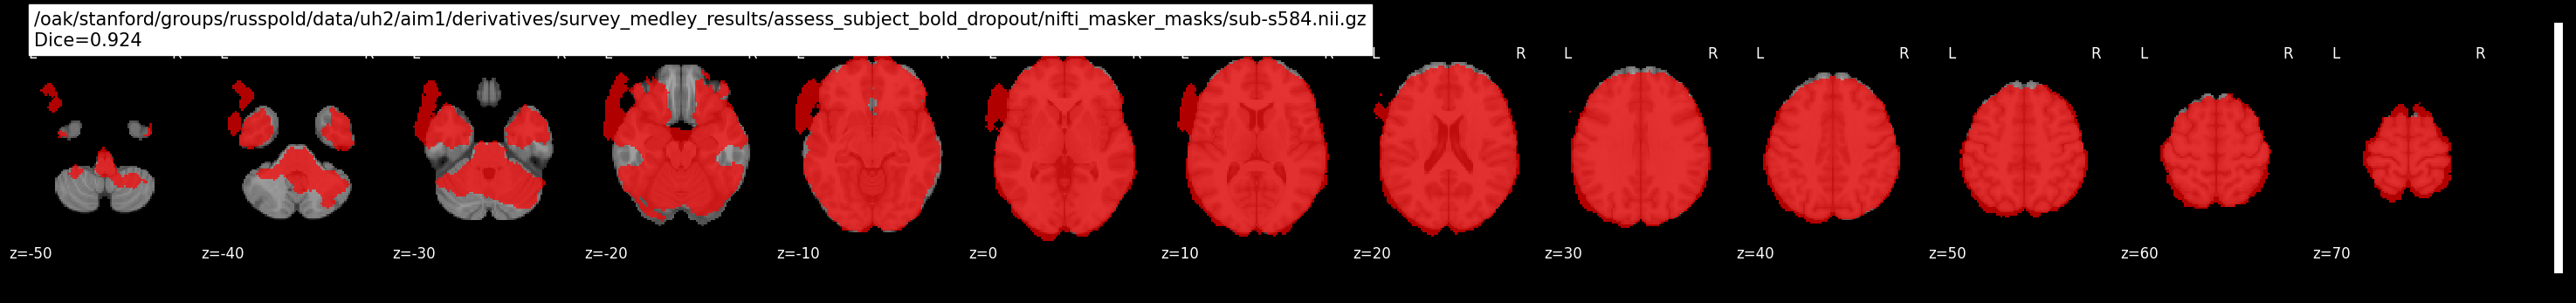

Plotting /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks/sub-s445.nii.gz (Dice=0.882)


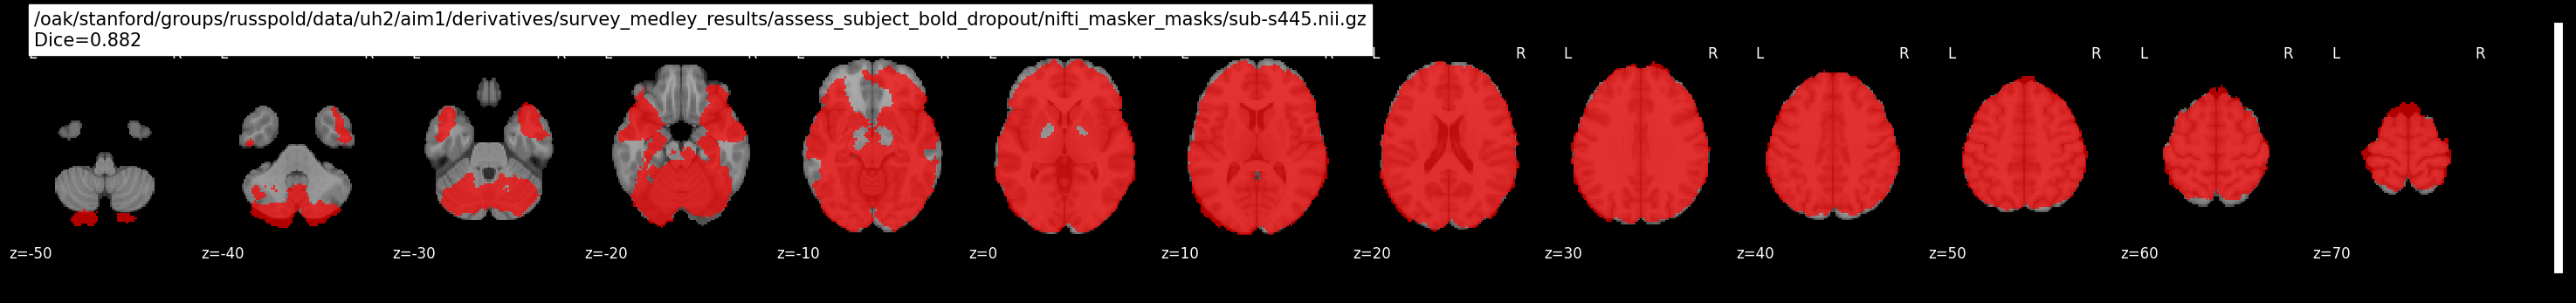

Plotting /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks/sub-s628.nii.gz (Dice=0.918)


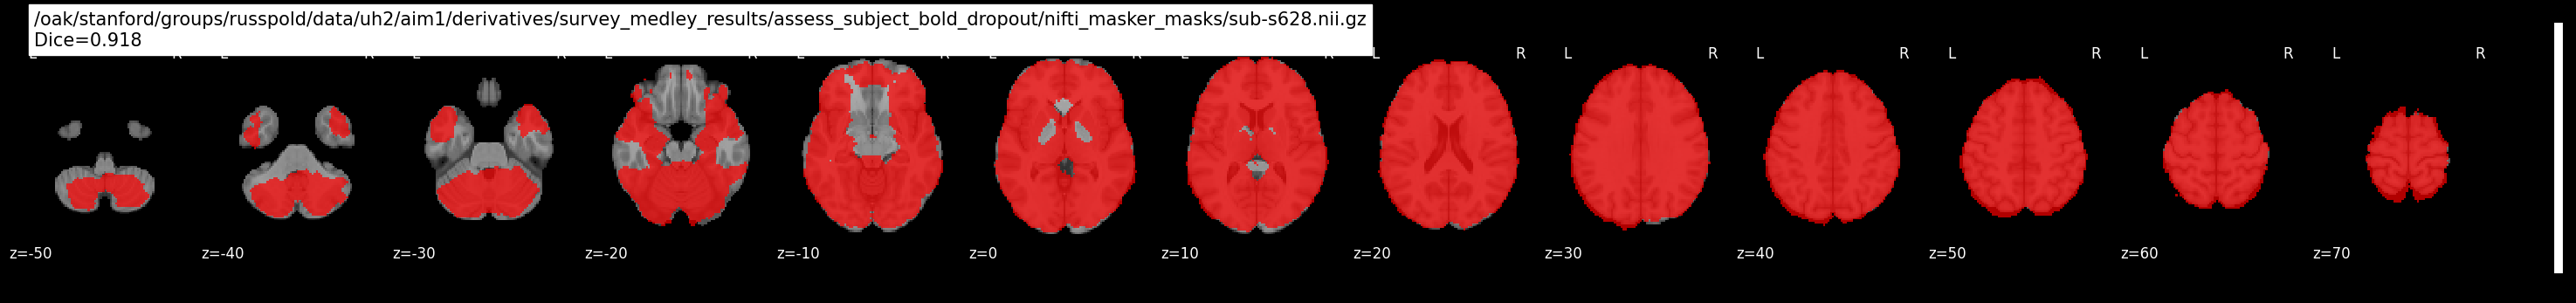

Plotting /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks/sub-s617.nii.gz (Dice=0.917)


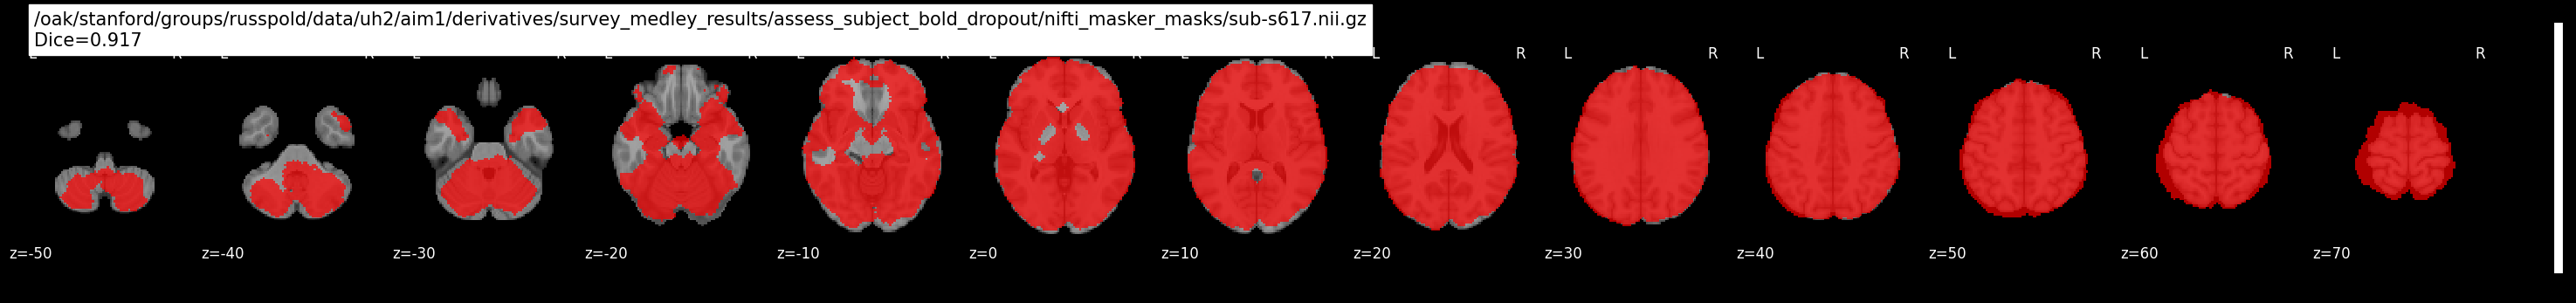

Plotting /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks/sub-s495.nii.gz (Dice=0.918)


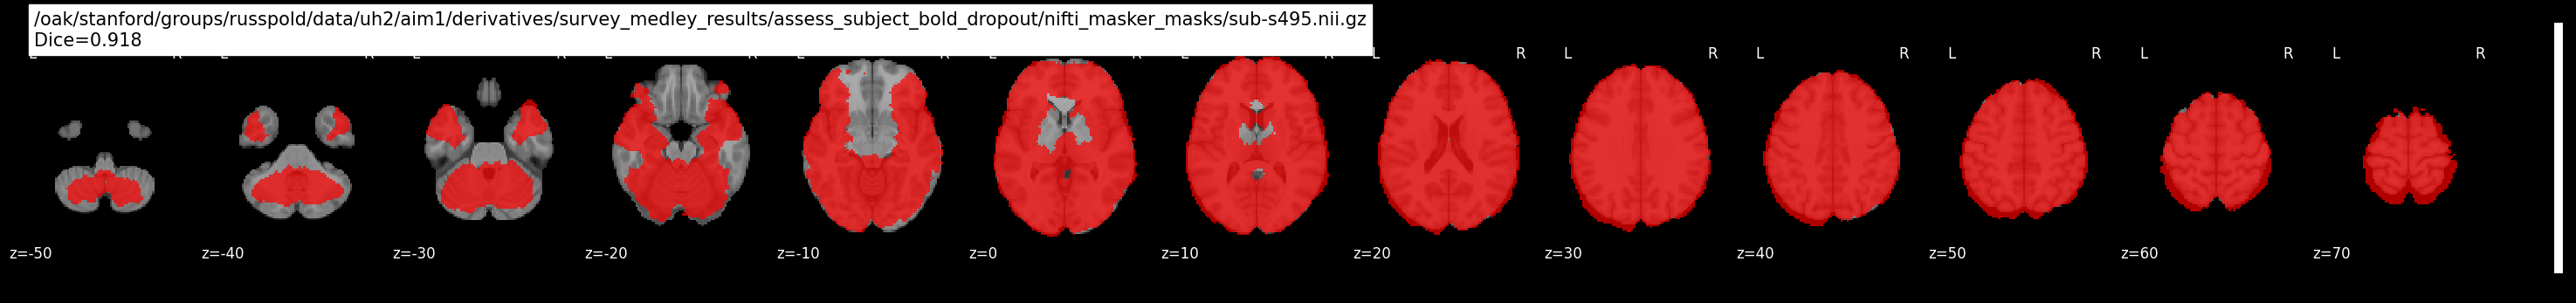

Plotting /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks/sub-s618.nii.gz (Dice=0.764)


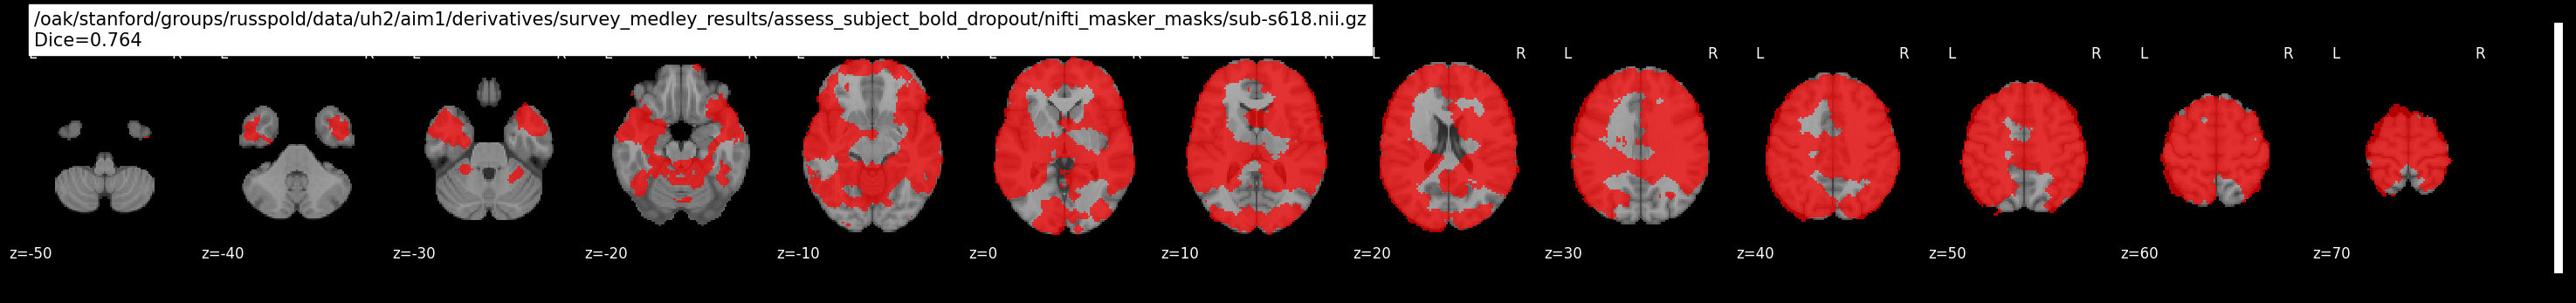

In [16]:
threshold = 0.93

# Loop through masks and dice scores
for mask_path, dice in zip(mask_list, dice_scores):
    if dice < threshold:
        print(f'Plotting {mask_path} (Dice={dice:.3f})')
        bad_mask_img = image.load_img(mask_path)

        plotting.plot_roi(
            bad_mask_img,
            display_mode='z',
            cut_coords=z_slices,
            cmap='autumn',
            black_bg=True,
            title=f'{mask_path}\nDice={dice:.3f}',
        )
        plt.show()

Plotting /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks/sub-s445.nii.gz (Dice=0.882)


/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/survey_medley_code/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2896: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


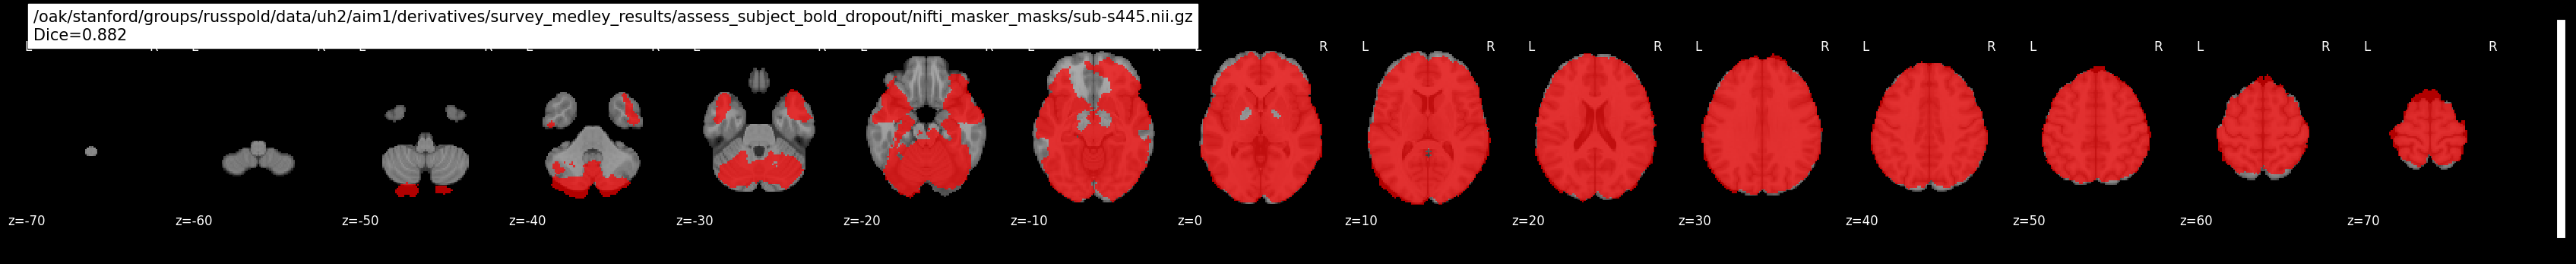

/tmp/ipykernel_32215/660122702.py:35: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_img = image.mean_img(bold_img)


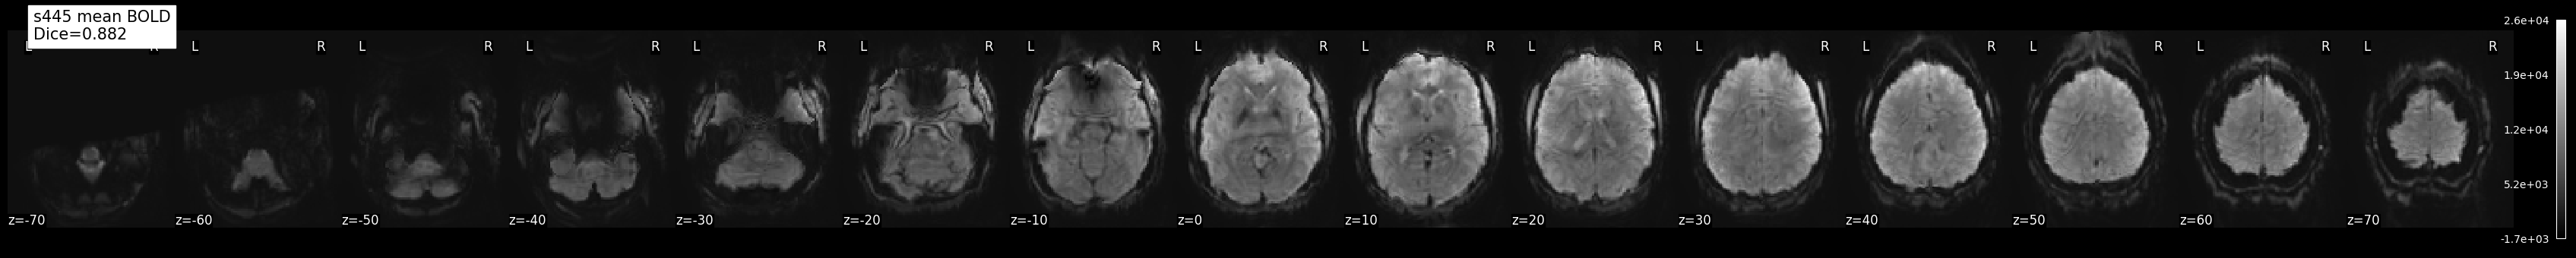

Plotting /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/assess_subject_bold_dropout/nifti_masker_masks/sub-s618.nii.gz (Dice=0.764)


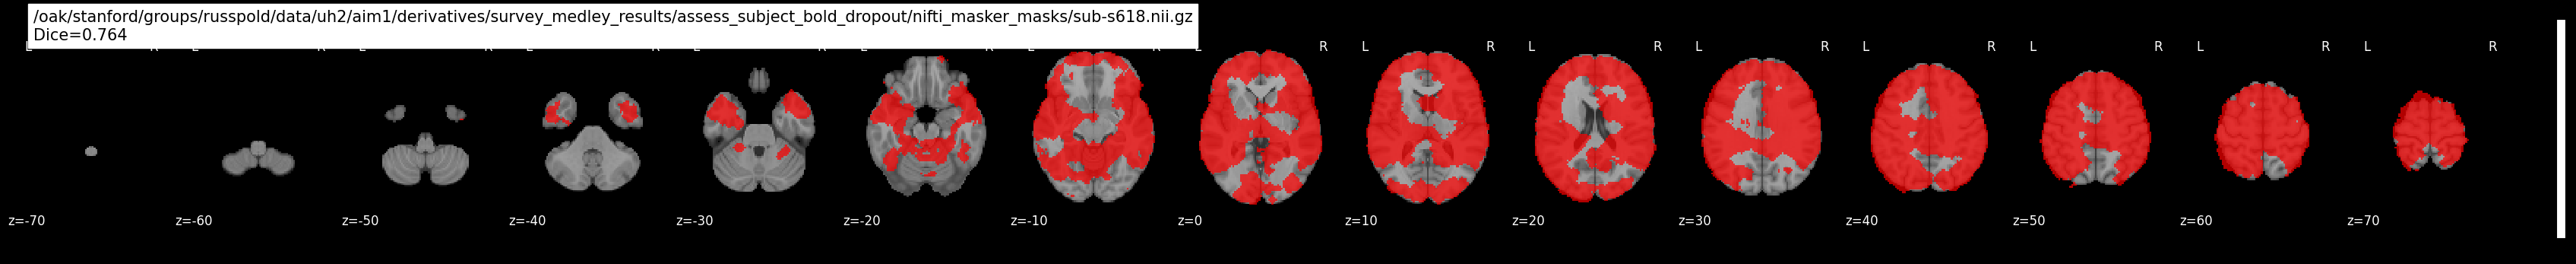

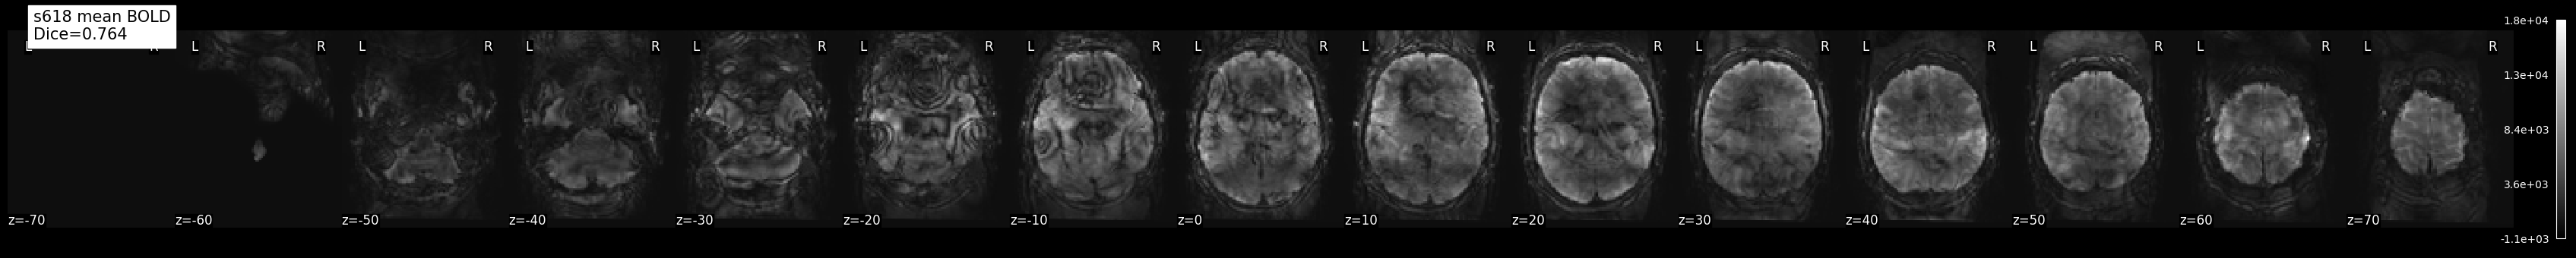

In [17]:
threshold = 0.9
bold_glob_pattern = '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/fmriprep/sub-{subid}/ses-*/func/sub-{subid}_ses-*_task-surveyMedley_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
z_slices = range(-70, 71, 10)

bad_mask_subs = []

for mask_path, dice in zip(mask_list, dice_scores):
    if dice < threshold:
        print(f'Plotting {mask_path} (Dice={dice:.3f})')
        bad_mask_img = image.load_img(mask_path)

        # --- Plot 1: mask only ---
        plotting.plot_roi(
            bad_mask_img,
            display_mode='z',
            cut_coords=z_slices,
            cmap='autumn',
            black_bg=True,
            title=f'{mask_path}\nDice={dice:.3f}',
        )
        plt.show()

        # --- Plot 2: mean functional (BOLD) ---
        # Extract subid from mask path
        subid = str(mask_path).split('/sub-')[1].split('.nii.gz')[0]

        # Find corresponding BOLD file
        bold_files = glob(bold_glob_pattern.format(subid=subid))
        if not bold_files:
            print(f'No BOLD file found for subid {subid}')
            continue
        bold_file = bold_files[0]

        bold_img = image.load_img(bold_file)
        mean_img = image.mean_img(bold_img)

        plotting.plot_epi(
            mean_img,
            display_mode='z',
            cut_coords=z_slices,
            title=f'{subid} mean BOLD\nDice={dice:.3f}',
        )
        plt.show()
        bad_mask_subs.append(subid)

In [18]:
# Generate list of good subjects based on Jaime's QA and this assessment

bad_mask_df = pd.DataFrame({'subid': bad_mask_subs})
bad_mask_df['bad_bold_mask'] = 1

In [19]:
final_merged_exclusions = pd.merge(
    bad_mask_df,
    merged_exclusions,
    on='subid',  # or 'subid' if that's the column name
    how='outer',  # keeps all rows from both DataFrames
)
final_merged_exclusions = final_merged_exclusions.fillna(0)

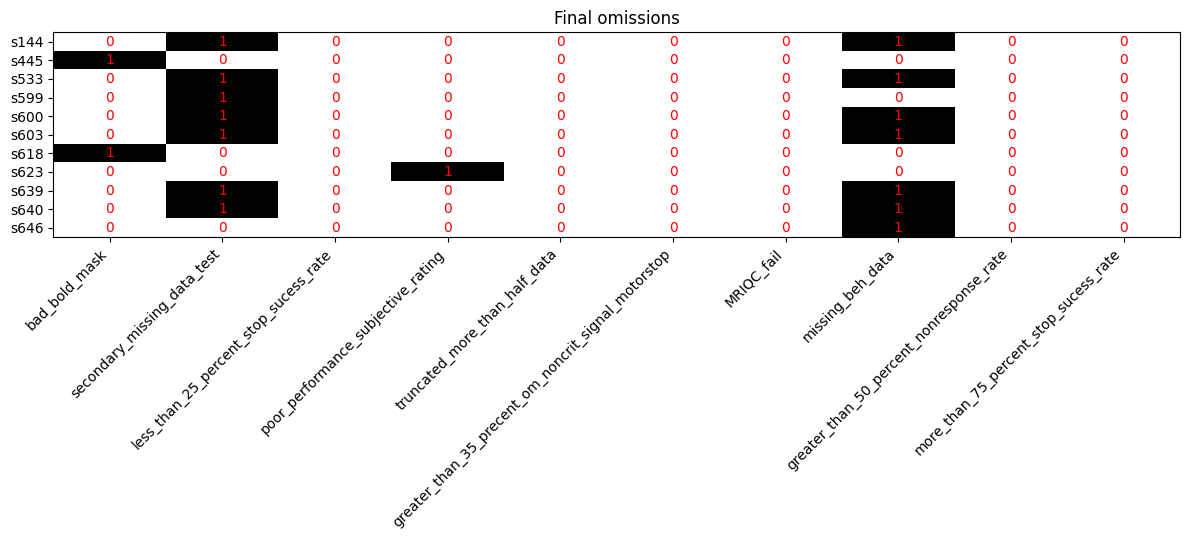

In [20]:
data = final_merged_exclusions.drop(columns=['subid']).values
subjects = final_merged_exclusions['subid'].values
columns = final_merged_exclusions.drop(columns=['subid']).columns

fig, ax = plt.subplots(
    figsize=(12, len(subjects) * 0.5)
)  # height scales with # of subjects
im = ax.imshow(data, cmap='Greys', aspect='auto')  # Greys: 0=white, 1=black

# Set ticks
ax.set_yticks(np.arange(len(subjects)))
ax.set_yticklabels(subjects)
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=45, ha='right')

# Optionally, add values on the cells
for i in range(len(subjects)):
    for j in range(len(columns)):
        ax.text(j, i, str(int(data[i, j])), ha='center', va='center', color='red')

ax.set_title('Final omissions')
plt.tight_layout()
plt.show()

In [21]:
good_sub_list = [
    subid for subid in subids if subid not in final_merged_exclusions['subid'].values
]


In [22]:
len(good_sub_list)

99

In [23]:
output_file = 'preanalysis_good_subject_list.txt'

with open(output_file, 'w') as f:
    for subid in good_sub_list:
        f.write(f'{subid}\n')